# Computational Essays on Artificial Intelligence
## Robot Memory

Imagine that you are a simple robot without memory. That is, your little "brain" has no capacity to save any information about your *state*. Your brain is just a straight-line process from your senses to actions. 

Did I mention that you don't have any memory? You could not answer that because you would have no memory of the previous sentence. Or can you? This essay explores how a robot without internal memory can still use the embodied world as an external memory.

This essay builds on the following essays:

1. [What is it like to be a robot?](https://github.com/ArtificialIntelligenceToolkit/aitk/blob/master/ComputationalEssays.md#what-is-it-like-to-be-a-robot)
1. [Evolving Robot Control](https://github.com/ArtificialIntelligenceToolkit/aitk/blob/master/ComputationalEssays.md#evolving-robot-control)

Further instructions for setting up your environment can be found in [AITK Python tools](https://github.com/ArtificialIntelligenceToolkit/aitk/blob/master/README.md#python-tools).

## 1. Setup

For this discussion, we will create a robot in a small world. The robot's brain will be a simple, 3-layer, feed-forward artificial neural network. We will use `aitk` for simulated robots and artifical neural networks. If you do not have this installed you will need to copy the following into a cell and execute it:

```ipython
%pip install aitk --upgrade --quiet
```

Next we import all of the libraries we will need:

In [23]:
from aitk.robots import World, Scribbler
from aitk.robots.utils import distance
from aitk.networks import Network
from aitk.algorithms import GeneticAlgorithm
from aitk.utils import Color

import numpy as np
import random
from tensorflow.keras.layers import Input, Dense

## 2. Experiment

The simulated environment will consist of a small, red Scribbler robot with 16 laser sensors. The robot is placed at the left end of a hallway. At the right end of the hallway is a light that is either yellow, orange, or off.

Initially, the light will be on. The robot's goal when the light is yellow is to make its way down the hallway, and turn left. If the light is orange, then when the robot get's to the end of the hallway, it is to turn right. The trick is that we turn the light off after 1.0 second. **The robot will have to remember what color the light was in order to complete the task.**

We create the simulated world and robots:

In [30]:
world = World(100, 100)
world.add_wall("blue", 0, 30, 65, 35)
world.add_wall("blue", 0, 70, 65, 65)
world.add_wall("blue", 65, 35, 70, 0)
world.add_wall("blue", 65, 65, 70, 100)
robot = Scribbler(10, 50, 0)
robot.add_device_ring("RangeSensor", 0, -180, 180, 16, 
                      width=0, max=100)
world.add_robot(robot)
world.add_bulb("yellow", 85, 50, 0, 20)
world.watch()

Random seed set to: 8570925


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

We write a function to gather the laser data. We will use the `get_reading()` method of the laser sensor device as it scales the reading between 0 and 1. Although it doesn't matter to a learning system, the `get_reading()` method returns 1.0 if no obstacle is detected, and a value between 0.0 and 1.0 if there is an obstacle where the lower the value means it is closer to the robot.

In [31]:
def get_sensor_array(robot):
    return [x.get_reading() for x in robot if x.type == "laser"]

In [32]:
print(get_sensor_array(robot))

[0.1, 0.10823922002923943, 0.1414213562373097, 0.16235883004385912, 0.15, 0.16235883004385915, 0.2121320343559642, 0.3919688894629123, 0.9, 0.39196888946291225, 0.2121320343559642, 0.1623588300438591, 0.15, 0.1623588300438591, 0.1414213562373095, 0.1082392200292394]


The laser sensor values are ordered starting at the back (-180 degrees) and sweep up the right side of the robot back around. There is no "noise" in the simulated world, so the sensor values are exact.

We can check to make sure there are 16 sensor readings:

In [10]:
len(get_sensor_array(robot))

16

Good! Now, we will create a 3-layer, feed-forward articial neural network. We will separate the "signal" (e.g., the light) from the "sensors" (e.g., the laser readings) on the input layer. We arbitrarily create a "hidden" layer with 10 units. Finally, we will use two output units for controlling translate and rotate, respectively. We somewhat arbirarily also decide to use the "sigmoid" activation function on the outputs of the hidden and output layers.

In [33]:
def create_network(robot):
    sensor_array = get_sensor_array(robot)
    network = Network(layers=[
        Input(1, name="signal"),
        Input(len(sensor_array), name="sensors"),
        Dense(10, name="hidden", activation="sigmoid"),
        Dense(2, name="output", activation="sigmoid"),
    ])
    network.connect("signal", "hidden")
    network.connect("sensors", "hidden")
    network.connect("hidden", "output")
    network.compile()
    return network

In [34]:
network = create_network(robot)

Connect layers with Network.connect(NAME, NAME) where NAMEs are in:
     ['signal', 'sensors', 'hidden', 'output']


We can issue a `network.watch()` to visually inspect the values as they propagate through the network:

<div class="alert alert-block alert-info">
    <p><b>Note</b>: In Jupyter Lab, you can position this display by right-clicking it and selecting "Create New View for Output".</p>
</div>

In [44]:
network.watch()

HTML(value='<div style="outline: 5px solid #1976D2FF; width: 400px; height: 209px;"><svg id=\'keras-network\' …

The idea is that we will gather the signal and sensor readings in order to propagate them through the network to get motor values for steering the robot.

To make this a little easy on the robot, we will create a virtual sensor for the light detection using the fallowing values:

* 1: means the light is **yellow** and the target destination requires a **left** turn at end of hallway
* -1: means the light is **orange** and the target destination requires a **right** turn at end of hallway
* 0: means the light is **off**

Let's see what the initial random weights say to do when the light is yellow:

In [45]:
network.propagate(
        [[1],  get_sensor_array(robot)],
)

array([0.6363351, 0.4188233], dtype=float32)

That will be interpreted as motor movements. But, because we are using the "sigmoid" activation function on the output layer, we need to scale those values between -1 and 1. We can do that by multiplying by 2, and subtracting 1:

In [46]:
network.propagate(
        [[1],  get_sensor_array(robot)],
) * 2 - 1

array([ 0.27267015, -0.1623534 ], dtype=float32)

Let's see what the initial random weights say to do when the light is orange:

In [47]:
network.propagate(
        [[-1],  get_sensor_array(robot)],
) * 2 - 1

array([ 0.2913952 , -0.16512197], dtype=float32)

If these values aren't very different, that isn't too surprising. During learning (e.g. evolution) we desire that the network will learn to drive the robot to the correct location. Recall that the light will turn off after one second. 

How big is this neural network? How many trainable weights does it have? We can answer that question by getting a summary of the model:

In [48]:
network.summary()

Model: "Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signal (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
sensors (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 17)           0           signal[0][0]                     
                                                                 sensors[0][0]                    
__________________________________________________________________________________________________
hidden (Dense)                  (None, 10)           180         concatenate_1[0][0]        

That gives 202 trainable weights. We can get those weights using `network.get_weights()`:

In [49]:
len(network.get_weights(flat=True))

202

## 3. Evolution

How hard would it be to find a solution to this problem? There are only 202 weights. Could we simply try all possible combinations?

Not really. Even though there are only 202 weights, we'd need to try at least a few values for each weight.

### Checkpoint 1

If we tried 3 values (say, -1, 0, and 1) for each of the 202 weights, how many combinations would that be?

In [50]:
202 ** 3

8242408

8 million. That would take some time. How much time on your computer? Would we be guaranteed to find a solution?

More likely, we would need to try a 100 values for each weight.

In [54]:
202 ** 100

342875887437181324649469611126324023400774813144032825723133199796565615740233412739295645320443897329063726782485430048961987632908813457983655771767729585235274943659061088290386775905366790625500913909055652811769012254068965376

## 3.1 The Genetic Algorithm

To effectively search this space of possibilities, we will use the Genetic Algorithm.

In [ ]:
class GA(GeneticAlgorithm):
    def __init__(self, world, network, popSize, **kwargs):
        self.world = world
        self.network = network
        self.length = len(self.network.get_weights(flat=True))
        self.black = Color("black")
        self.white = Color("white")
        super().__init__(self.length, popSize, **kwargs)



We then add the following methods:

* controller() - the robot control program
* is_done() - signals evolution is complete
* make_random_gene() - code to make a new random gene (e.g. weight) 
* mutate_gene() - code to mutate a gene
* fitness() - the fitness function
 
 The fitness function will be the distance from the target. Because we value high fitness, we subtract the distance from 500.

In [60]:
class GA(GA):
    def controller(self, robot):
        if robot.stalled:
            return True
        signal = np.array([robot.state["signal"]])
        sensors = get_sensor_array(robot)
        output = self.network.propagate(
            [signal, sensors],
            show=robot.state["show"]) * 2 - 1
        robot.move(*output)
        if robot.state["count"] >= 10:
            robot.state["signal"] = 0.0
            robot.world.bulbs[0].off()
        elif robot.state["count"] == 0:
            robot.world.bulbs[0].on()
            if robot.state["signal"] == 1:
                robot.world.bulbs[0].set_color("yellow")
            else: 
                robot.world.bulbs[0].set_color("orange")
        robot.state["count"] += 1
        
    def is_done(self):
        return self.bestEverScore > 495
        
    def make_random_gene(self):
        return 1 - random.random() * 2
    
    def mutate_gene(self, gene):
        return gene + 0.05 - random.random() * 0.10

    def fitness(self, chromosome, index=None, seconds=8.0, real_time=False):
        robot = world.robots[0]
        robot.state["show"] = real_time
        self.network.set_weights(chromosome)
        total = 0
        for signal, target in [(1, (85, 10)), 
                                (-1, (85, 90))]:
            robot.state["signal"] = signal
            robot.state["count"] = 0
            robot.set_pose(10, 50, 0)
            robot.world.canvas.clear()
            for color, radius in [(self.black, 6), (self.white, 4), (self.black, 2)]:
                robot.world.canvas.set_stroke_style(color, 1)
                robot.world.canvas.set_fill_style(color)
                robot.world.canvas.draw_circle(
                    target[0], target[1], radius)
            self.world.seconds(
                seconds, 
                [self.controller], 
                real_time=real_time,
                show=True,
                show_progress=real_time, 
                interrupt=True,
                quiet=True)
            total += distance(robot.x, robot.y, 
                              target[0], target[1])
        return 500 - total


We'll re-use the world and network created above, and try with a population of 50 chromosomes. In this example, a chromosome is a set of the 202 weights. Initially, those will all be random values between -1 and 1.

In [61]:
ga = GA(world, network, 50)

Genetic algorithm
  Chromosome length: 202
  Population size: 50


Again, we can watch the statistics of the population using a watcher:

In [62]:
ga.watch()

HTML(value='<?xml version="1.0" encoding="utf-8" standalone="no"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1/…

To test a random chromosome and watch it, we simply:

In [63]:
ga.fitness(ga.make_random_chromosome(), real_time=True)

331.8775965812296

Notice that during processing, the light will turn off and on, and change color as necessary. There is also a target destination drawn. However, the robot cannot see it.

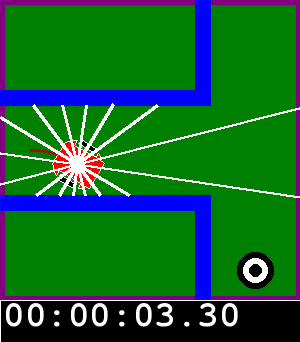

In [59]:
world.get_image()

Ok, now we are ready to evolve a solution. Initially, we set the maximum generations to 10. But this is a hard problem, so likely need to set the maximum generations to closer to 300 to actually find a solution. On my laptop, it typically takes about 10 seconds a generation.

In [65]:
best = ga.evolve(10, elite_percent=.020, mutation_rate=0.01)

Maximum number of generations: 10
  Elite percentage 0.02 (1/50 chromosomes per generation)
  Crossover rate: 0.7 (~34/49 crossovers per generation)
  Mutation rate: 0.01 (~197/9898 genes per generation)


  0%|          | 0/8 [00:00<?, ?it/s]

Max generations reached


Let's watch the best in real time:

In [66]:
ga.fitness(best, real_time=True)

421.25066109277896

Because this is a hard problem and requires a bit of computation to find a solution, we'll provide one here. Here is a set of weights (e.g., a chromosome):

In [67]:
saved_weights = [
    0.02, 0.76, -0.51, -0.68, -0.82, 0.86, -0.96, 0.45, -0.5, 
    0.78, 0.34, -0.27, -0.88, -1.01, -0.21, 0.34, -0.05, 0.48, 
    -0.84, 0.38, -0.57, 0.14, -0.65, 0.12, -0.68, -0.79, 0.22, 
    0.07, 0.17, -0.46, 0.3, -1.0, -0.65, -0.02, -0.65, 0.94, 
    -0.74, 0.53, 0.62, 0.16, 0.65, -0.28, 0.42, -0.12, 0.66, 
    0.58, 0.91, 0.02, 0.2, 0.64, -0.75, -0.15, -0.42, -0.71, 
    0.16, -0.88, 0.89, -0.16, 0.45, 0.27, -0.16, 0.73, 0.38, 
    -0.42, 0.32, 0.49, 0.23, 1.0, -0.08, -0.31, -0.45, 0.12, 
    -0.85, 0.07, -0.47, -0.11, 0.81, 0.47, 0.61, -0.09, 0.95, 
    1.01, -0.96, 0.24, -0.89, 0.07, 0.79, -0.4, 0.71, 0.29, 
    0.22, 0.29, -0.39, 0.86, 0.73, -0.77, -0.31, 0.1, -0.35, 
    0.59, -0.66, -0.3, 0.54, -0.89, -0.07, -0.25, 0.69, -0.32, 
    -0.27, 0.48, 0.04, -0.05, 0.43, -0.14, 0.92, 0.25, -0.59, 
    0.77, -0.14, -0.21, 0.22, -0.68, 1.02, -0.12, 0.08, -0.13, 
    -0.07, 0.01, 0.45, 0.85, 0.35, 0.22, 0.73, 0.39, 0.56, 0.06, 
    0.49, 0.33, 0.96, 0.24, 0.93, 0.77, 0.11, -0.03, -0.96, 0.95, 
    0.52, -1.05, -0.53, 0.64, -0.63, -0.2, -0.78, 0.03, -0.92, 
    0.36, 0.52, -0.14, -0.96, 0.52, -0.43, -0.41, -0.84, -0.01, 
    0.83, 0.06, -0.87, -0.96, -0.55, -0.45, -0.47, -0.7, 0.84, 
    -0.55, -0.83, 0.76, 0.75, 0.76, 0.55, -0.19, 0.37, 0.45, 
    0.95, -0.94, -0.35, 0.84, 0.87, 0.8, -0.21, 0.82, 0.48, 0.35, 
    0.51, 0.12, -0.44, -0.42, 0.03, -0.41, 1.0, 0.84, -0.88, -0.97
]

Let's check out its performance:

In [68]:
ga.fitness(saved_weights, seconds=15, real_time=True)

497.3044822769719

## 4. Analysis

We have just seen that a robot without memory can remember. This raises some questions:

1. How can the robot remember which way to turn given that it doesn't have any memory?
1. What implications does this have for testing memory-based systems?
1. Do you use this same "trick" in your own life?
